Question 2: Logistic Regression from Scratch with ROC-AUC
You are given a medical dataset to predict whether a patient has a disease (1) or not (0). You are
not allowed to use sklearn's LogisticRegression.

In [2]:
import pandas as pd
import numpy as np  
df=pd.read_csv('diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
X = df.drop("Outcome", axis=1).values
y = df["Outcome"].values

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (768, 8)
y shape: (768,)


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [5]:
def standardize(X):
    mean = X.mean(axis=0)
    std = X.std(axis=0) + 1e-8
    return (X - mean) / std, mean, std

X_train, mean, std = standardize(X_train)
X_test = (X_test - mean) / std


In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))
print(sigmoid(0))    


0.5


In [7]:
def binary_cross_entropy(y_true, y_pred):
    eps = 1e-9
    y_pred = np.clip(y_pred, eps, 1-eps)
    
    loss = -np.mean(
        y_true*np.log(y_pred) + (1-y_true)*np.log(1-y_pred)
    )
    return loss


In [8]:
y_true = np.array([1,0,1])
y_pred = np.array([0.9,0.2,0.8])

print(binary_cross_entropy(y_true, y_pred))


0.18388253942874858


In [9]:
n_features = X_train.shape[1]

w = np.zeros(n_features)
b = 0

print("Weights:", w)
print("Bias:", b)


Weights: [0. 0. 0. 0. 0. 0. 0. 0.]
Bias: 0


In [10]:
def predict_proba(X, w, b):
    z = np.dot(X, w) + b
    return sigmoid(z)
print(predict_proba(X_train[:5], w, b))


[0.5 0.5 0.5 0.5 0.5]


In [11]:
def gradient_descent(X, y, w, b, lr):
    n = len(y)
    
    # Forward pass
    y_pred = predict_proba(X, w, b)
    
    # Gradients
    dw = (1/n) * np.dot(X.T, (y_pred - y))
    db = (1/n) * np.sum(y_pred - y)
    
    # Update
    w = w - lr * dw
    b = b - lr * db
    
    return w, b


In [13]:
lr = 0.1
epochs = 2000

for i in range(epochs):
    w, b = gradient_descent(X_train, y_train, w, b, lr)
    
    # Monitor loss every 400 epochs
    if i % 400 == 0:
        y_temp = predict_proba(X_train, w, b)
        loss = binary_cross_entropy(y_train, y_temp)
        print("Epoch:", i, "Loss:", loss)
y_prob = predict_proba(X_test, w, b)

print("First 10 predicted probabilities:")
print(y_prob[:10])
y_pred = (y_prob >= 0.5).astype(int)

print("First 10 predicted class labels:")
print(y_pred[:10])



Epoch: 0 Loss: 0.46783506790321433
Epoch: 400 Loss: 0.46783506790288215
Epoch: 800 Loss: 0.4678350679028794
Epoch: 1200 Loss: 0.4678350679028794
Epoch: 1600 Loss: 0.46783506790287926
First 10 predicted probabilities:
[0.27470549 0.18496763 0.11271606 0.16775377 0.46818974 0.43859619
 0.01530161 0.66859882 0.5388547  0.77506088]
First 10 predicted class labels:
[0 0 0 0 0 0 0 1 1 1]


In [14]:
def confusion_matrix_manual(y_true, y_pred):
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    
    return TP, TN, FP, FN
TP, TN, FP, FN = confusion_matrix_manual(y_test, y_pred)

print("Confusion Matrix:")
print("TP:", TP)
print("TN:", TN)
print("FP:", FP)
print("FN:", FN)


Confusion Matrix:
TP: 37
TN: 79
FP: 20
FN: 18


In [15]:
def precision_recall_f1(y_true, y_pred):
    TP, TN, FP, FN = confusion_matrix_manual(y_true, y_pred)
    
    precision = TP / (TP + FP + 1e-9)
    recall    = TP / (TP + FN + 1e-9)
    f1        = 2 * precision * recall / (precision + recall + 1e-9)
    
    return precision, recall, f1
precision, recall, f1 = precision_recall_f1(y_test, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Precision: 0.6491228070061558
Recall: 0.6727272727150414
F1 Score: 0.6607142852026466


In [17]:
def roc_curve_manual(y_true, y_prob, thresholds=np.linspace(0,1,100)):
    TPR = []
    FPR = []
    
    for t in thresholds:
        y_pred = (y_prob >= t).astype(int)
        TP, TN, FP, FN = confusion_matrix_manual(y_true, y_pred)
        
        tpr = TP / (TP + FN + 1e-9)   # Sensitivity
        fpr = FP / (FP + TN + 1e-9)   # 1 - Specificity
        
        TPR.append(tpr)
        FPR.append(fpr)
        
    return np.array(FPR), np.array(TPR)
FPR, TPR = roc_curve_manual(y_test, y_prob)

print("FPR sample:", FPR[:5])
print("TPR sample:", TPR[:5])



FPR sample: [1.         0.97979798 0.94949495 0.91919192 0.8989899 ]
TPR sample: [1.         1.         1.         1.         0.98181818]


In [18]:
def auc_manual(FPR, TPR):
    order = np.argsort(FPR)
    FPR = FPR[order]
    TPR = TPR[order]
    
    return np.trapz(TPR, FPR)
auc_score = auc_manual(FPR, TPR)
print("AUC Score:", auc_score)


AUC Score: 0.8151515151284604


C:\Users\Asus\AppData\Local\Temp\ipykernel_3496\1501961777.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(TPR, FPR)


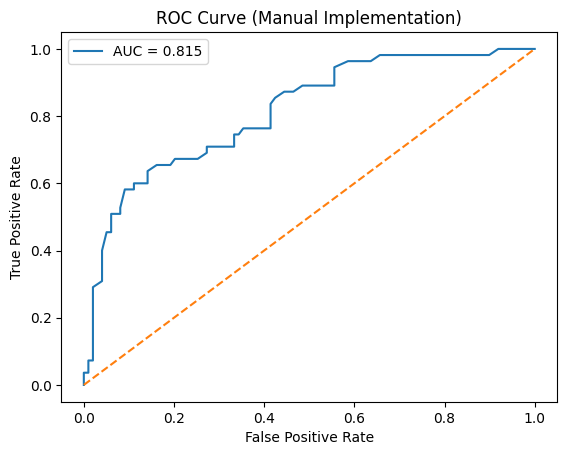

In [19]:
import matplotlib.pyplot as plt

plt.plot(FPR, TPR, label="AUC = " + str(round(auc_score,3)))
plt.plot([0,1], [0,1], '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Manual Implementation)")
plt.legend()
plt.show()


In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

sk_model = LogisticRegression(max_iter=3000)
sk_model.fit(X_train, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,3000
,multi_class,'deprecated'


In [21]:
sk_prob = sk_model.predict_proba(X_test)[:,1]
sk_auc = roc_auc_score(y_test, sk_prob)

print("Sklearn AUC:", sk_auc)
print("Scratch Model AUC:", auc_score)


Sklearn AUC: 0.8146923783287419
Scratch Model AUC: 0.8151515151284604


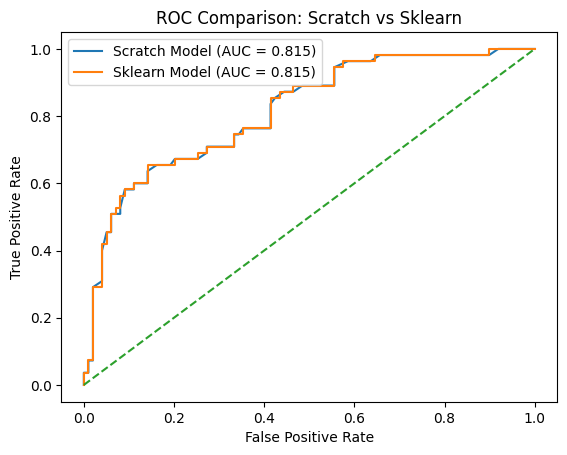

In [22]:
from sklearn.metrics import roc_curve

fpr_sk, tpr_sk, _ = roc_curve(y_test, sk_prob)

plt.plot(FPR, TPR, label="Scratch Model (AUC = " + str(round(auc_score,3)) + ")")
plt.plot(fpr_sk, tpr_sk, label="Sklearn Model (AUC = " + str(round(sk_auc,3)) + ")")
plt.plot([0,1],[0,1],'--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Comparison: Scratch vs Sklearn")
plt.legend()
plt.show()


In [23]:
#Gradient Descent with L2 Regularization
def gradient_descent_l2(X, y, w, b, lr, l2):
    n = len(y)
    
    y_pred = predict_proba(X, w, b)
    
    dw = (1/n) * np.dot(X.T, (y_pred - y)) + 2*l2*w
    db = (1/n) * np.sum(y_pred - y)
    
    w = w - lr * dw
    b = b - lr * db
    
    return w, b
l2_values = [0.0, 0.01, 0.1, 1.0]

for l2 in l2_values:
    w_reg = np.zeros(X_train.shape[1])
    b_reg = 0
    
    for _ in range(2000):
        w_reg, b_reg = gradient_descent_l2(
            X_train, y_train, w_reg, b_reg, lr=0.1, l2=l2
        )
    
    prob_reg = predict_proba(X_test, w_reg, b_reg)
    FPR_reg, TPR_reg = roc_curve_manual(y_test, prob_reg)
    auc_reg = auc_manual(FPR_reg, TPR_reg)
    
    print("L2 =", l2, "| AUC =", round(auc_reg,3))


L2 = 0.0 | AUC = 0.815
L2 = 0.01 | AUC = 0.816
L2 = 0.1 | AUC = 0.813
L2 = 1.0 | AUC = 0.797


C:\Users\Asus\AppData\Local\Temp\ipykernel_3496\1501961777.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(TPR, FPR)


The ROC curve and AUC value of my model is almost same as the sklearn LogisticRegression model. This shows that the gradient descent and loss function is working correctly. Small difference happens because of learning rate, number of iterations and internal optimization used by sklearn.

L2 regularization helps in reducing large weights and makes the model less complex. When L2 is zero, the model can slightly overfit the data. If we use moderate L2 value, the model performs more stable and gives better generalization. Very large L2 value can cause underfitting because weights become too small. From this experiment we can see that regularization helps to control overfitting.

In [24]:
# part B

Question 4: Model Selection Under Business Constraints


## 1. Model Selection for Fraud Detection

I would choose Logistic Regression with class weighting or Random Forest for this fraud detection system.

Reasons::

1.Fast prediction:  
Both models are fast and suitable for real time fraud detection where decision must be taken quickly.

2.Handles large dataset:  
These models can work well with large amount of data and give stable performance.

3.Handles imbalanced data:  
Class weighting can be used so that fraud samples get more importance during training.

4.Interpretability:  
Logistic Regression is easy to understand and explain which is important for banking rules and audits.

5.Better pattern learning:  
Random Forest can learn complex and non linear fraud patterns better.

so Logistic Regression ill choose


## 2. Most Important Metric

The most important metric in fraud detection is Recall.

Recall tells how many actual fraud cases are correctly detected by the model. In banking system, missing a fraud transaction can cause big financial loss and customer trust issue.

If the model has high accuracy but low recall, it means it predicts most transactions as normal and many fraud cases are missed. This is dangerous for the bank.

Precision is also important, but in this case catching fraud is more important than sometimes wrongly flagging normal transaction.

So recall should be given more priority than accuracy, precision or F1-score in fraud detection problem.


## 3. Handling Class Imbalance

Class imbalance can be handled using different techniques.

1.oversampling, where fraud samples are increased using methods like SMOTE so that model can learn fraud patterns better.

2.under sampling , where some normal samples are removed to balance the dataset, but sometimes this may cause loss of information.

3.class weighting, where more weight is given to fraud class during training so model focus more on fraud cases.

4.threshold tuning   where decision threshold is adjusted instead of using default 0.5 probability.

Using combination of these methods can help model perform better on imbalanced data.


## 4. Meaning of High Accuracy but Low Recall

If accuracy is high but recall is low, it means the model is predicting most transactions as normal and missing many fraud cases.

Because dataset is highly imbalanced, even if model predicts all transactions as normal, accuracy will still look high. But practically this is very risky because fraud transactions are not getting detected.

This situation means false negatives are high, which can cause financial loss for bank and affect customer trust.

So high accuracy alone does not mean model is performing well in fraud detection. Recall should also be considered seriously.


## 5. Complete ML Pipeline Design

A complete machine learning pipeline for fraud detection is designed as:

**Data Preprocessing:**  
First we clean the data by handling missing values, removing duplicate records and fixing incorrect entries. Categorical features can be encoded into numerical form. Outliers can also be checked because they can affect model performance.

**Feature Scaling:**  
Features should be scaled using standardization or min max scaling so that all features are in similar range. This helps models converge faster and perform better.

**Resampling Strategy:**  
Because data is imbalanced, oversampling methods like SMOTE or class weighting can be used to balance fraud and normal samples. Sometimes undersampling can also be applied if dataset is very large.

**Model Training:**  
Train the model using Logistic Regression or Random Forest. Cross validation can be used to tune hyperparameters and avoid overfitting.

**Model Evaluation:**  
Evaluate the model using recall, F1 score, ROC AUC and confusion matrix. Accuracy alone should not be trusted in imbalanced data. Model performance should be tested on unseen data.
